In [13]:
import pyloudnorm as pyln
from tensorflow.keras.models import load_model
from utils import preprocess_video
import argparse, json, os
import numpy as np
import pandas as pd
# from vueprep.settings import BASE_DIR

In [20]:
ImpressNet_video = load_model(os.path.join('./models/', 'ImpressNet_Fused.hdf5'))
Speech_Detector  = load_model(os.path.join('./models/', 'Speech_Detector.hdf5'))

def get_Recording_quality(v,a,s,t,e):

    res_cln = {}

    LUFS = pyln.Meter(22050).integrated_loudness(a)
    res_cln['loudness'] = 0 if LUFS<-55 else 1 if LUFS<-35 else 2 if LUFS<-15 else 10
    res_cln['speech'] = 0 if np.argmax(Speech_Detector(np.expand_dims(s,0)).numpy())!=1 else 1
    res_cln['facial'] = 0 if t.dropna().shape[0]<5 else 1 if t.dropna().shape[0]<15 else 2
    res_cln['occlusion'] = 0 if e>=4 else 1
    res_cln['blurness'] = 0 if t['blur_blurness_value'].mean()<20 else 1
    res_cln['lighting'] = 0 if np.mean(v)<0.2 else 1 if np.mean(v)<.75 else 10

    return res_cln

def get_ImpressNet_res(v,s,e):

    res_raw = ImpressNet_video([np.expand_dims(v,0),
                                np.expand_dims(s,0),
                                np.expand_dims(e,0)])
    res_key = ['interview','openness','conscientiousness',
               'extraversion','agreeableness','neuroticism']
    res_cln = {}
    for i in res_key:
        res_cln[i]=60+int((res_raw[i+'_bin'].numpy())*40)

    tot_scr = np.mean(list(res_cln.values()))
    res_cln.update({'overall':tot_scr})

    return res_cln

def get_Attribute_res(t):

    res_raw = t.mean(axis=0)
    res_cln = {}

    # face
    res_cln['gender'] = res_raw['gender_value']
    res_cln['age'] = int(res_raw['age_value'])
    gender = 'male' if res_cln["gender"]<.5 else 'female'
    res_cln['beauty'] = int(res_raw[f'beauty_{gender}_score'])

    # affect
    res_cln['smile'] = int(res_raw['smile_value'])
    res_cln['emotion'] = np.argmax(res_raw[sorted([i for i in res_raw.index if 'emotion' in i])].values)

    # gaze
    eyegaze_x = abs(res_raw[[i for i in res_raw.index if 'x_component' in i]].mean())<0.2
    eyegaze_y = abs(res_raw[[i for i in res_raw.index if 'y_component' in i]].mean())<0.2
    res_cln['eyegaze'] = eyegaze_x+eyegaze_y

    return res_cln

In [9]:
fp='/kellogg/proj/dwa382/Video_Analysis/Data/sample_videos/20005551.mp4'
SR=22050;FPS=2;DT=15;IMSIZE=224;plot=True

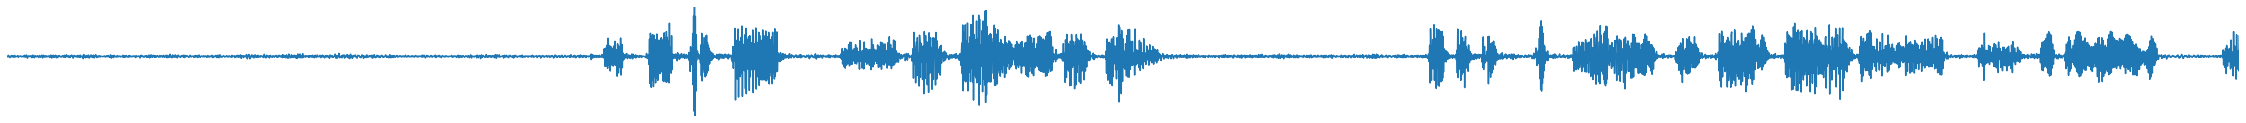

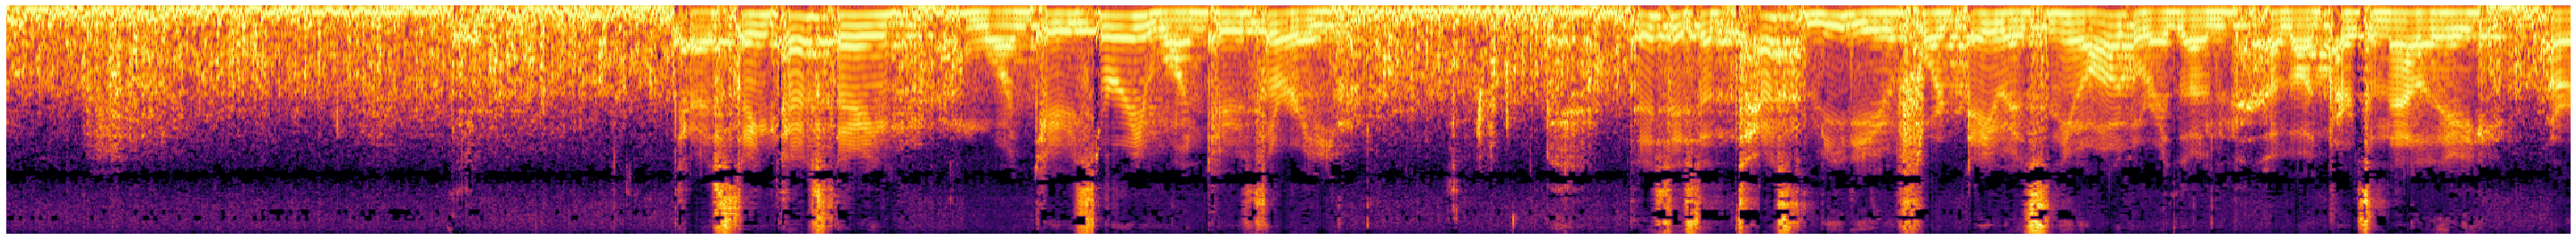

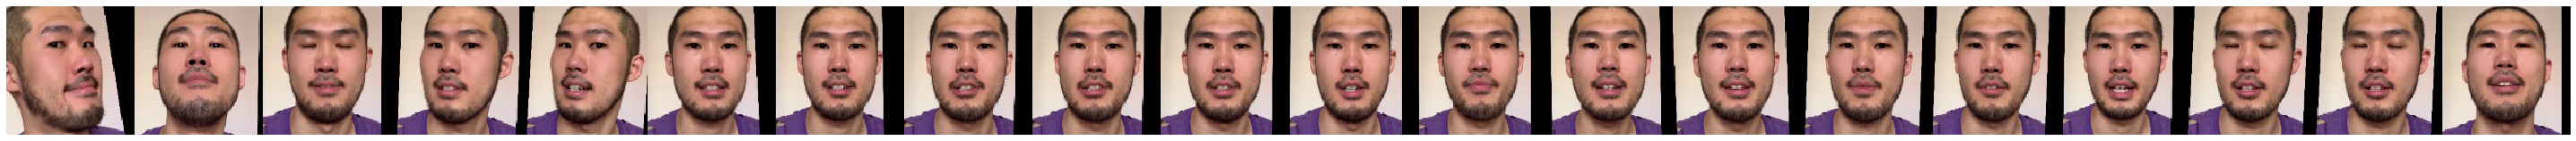

In [17]:
chunks = preprocess_video(fp,plot=plot)

In [18]:
if chunks is not None:

    facial_attributes = {}
    personality_traits = {}
    recording_quality = {}
    error = 0

    for n,chunk in enumerate(chunks):

        t = chunk['attrb'].fillna(chunk['attrb'].mean())
        e = t[sorted([i for i in t.columns if 'emotion' in i])+['smile_value']].values

        facial_attributes[n] = get_Attribute_res(t)
        personality_traits[n] = get_ImpressNet_res(chunk['video'],chunk['spect'],e)
        recording_quality[n] = get_Recording_quality(chunk['video'],chunk['audio'],
                                                     chunk['spect'],chunk['attrb'],chunk['score'])

        error += 1 if (((recording_quality[n]['facial']==0) and\
                        (recording_quality[n]['lighting']==0)) or\
                       (recording_quality[n]["loudness"]==0 and\
                        recording_quality[n]["speech"]==0)) else 0

    res = {'recording_quality':dict(pd.DataFrame.from_dict(recording_quality).mean(axis=1)),
           'facial_attributes':dict(pd.DataFrame.from_dict(facial_attributes).mean(axis=1)),
           'personality_traits':dict(pd.DataFrame.from_dict(personality_traits).mean(axis=1))}

#     if error == 0:
#         return res
#     else:
#         return {'error': True, 'msg': 'Response not detected! Check your camera or microphone.'}

# else:
#     return {'error': True, 'msg':'Response too short! Please record a longer response.'}

In [19]:
res

{'recording_quality': {'blurness': 0.0,
  'facial': 2.0,
  'lighting': 1.0,
  'loudness': 2.0,
  'occlusion': 0.0,
  'speech': 1.0},
 'facial_attributes': {'age': 27.0,
  'beauty': 59.0,
  'emotion': 4.0,
  'eyegaze': 1.0,
  'gender': 0.0,
  'smile': 8.0},
 'personality_traits': {'agreeableness': 86.0,
  'conscientiousness': 92.0,
  'extraversion': 91.0,
  'interview': 93.0,
  'neuroticism': 84.0,
  'openness': 85.0,
  'overall': 88.5}}

In [5]:
v_array,a_array = open_video(src_fp,FPS=FPS,SR=SR)

In [7]:
len(v_array)

47

In [ ]:
'.webm'